In [1]:
import csv
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = (16,9)
rcParams['font.size'] = 12
import numpy as np
import scipy as sp
import os 
import glob
import pandas as pd
import seaborn as sns

#pd.set_option("display.max_rows", None, "display.max_columns", None)

data_path = os.getcwd()
data_extension = "csv"

os.chdir(data_path)

In [2]:
result = [file for file in glob.glob("/home/juergen/Desktop/logs_phase1/" + '*.{}'.format(data_extension))]
participants, hashes = result.pop(result.index('/home/juergen/Desktop/logs_phase1/pids_phase1.csv')), result.pop(result.index('/home/juergen/Desktop/logs_phase1/hashes_phase1.csv'))

In [3]:
dff = [pd.read_csv(f, delimiter = ',') for f in result]

concats = {}

for df in dff:
    condition_id = list(df["condition_id"])[0]
    
    if not condition_id in concats:
        concats[condition_id] = df
    else:
        concats[condition_id] = pd.concat([concats[condition_id], df])
        
dff = concats.values()

pids = list(concats[0].pid.unique())

In [4]:
import math

class Run:
    def __init__(self, data):
        self.data = data
                        
        self.condition = list(data["condition_id"])[0]
        
        self.pid = list(data["pid"])[-1]        
        self.run_id = list(data["run_id"])[-1]
        self.run_starttime = list(data["timestampConditionStart"])[0]
        self.successful_click_time = list(data["timestampClick"])[-1]
        
        self.run_duration = float(self.successful_click_time) - float(self.run_starttime)
        self.errors = len(list(data["timestampClick"])) - list(data["timestampClick"]).count("oldval") - 1
              
        ###########################
        self.collisions = 0
        initial_collision_ts = list(data["timestampCollision"])[0]

        for i in list(data["timestampCollision"]):
            if initial_collision_ts != i:
                self.collisions += 1
                initial_collision_ts = i        
        
        ##############################
       
        self.num_cursor_movements = 0
        self.cursor_movement_length = 0
        self.num_target_movements = 0
        self.target_movement_length = 0
        
        initial_cursor_x = int(float(list(data["cursorX"])[0]))
        initial_cursor_y = int(float(list(data["cursorY"])[0]))
        initial_target_x = int(float(list(data["targetX"])[0]))
        initial_target_y = int(float(list(data["targetY"])[0]))
        
        for i in range(0, len(list(data["cursorX"]))):
            x, y = int(float(list(data["cursorX"])[i])), int(float(list(data["cursorY"])[i]))
            tx, ty = int(float(list(data["targetX"])[i])), int(float(list(data["targetY"])[i]))
            
            if x != initial_cursor_x or y != initial_cursor_y:
                self.cursor_movement_length += self.vector_length(x - initial_cursor_x, y - initial_cursor_y)
                self.num_cursor_movements += 1
                initial_cursor_x = x
                initial_cursor_y = y
                
            if tx != initial_target_x or ty != initial_target_y:
                self.num_target_movements += 1
                self.target_movement_length += self.vector_length(tx - initial_target_x, ty - initial_target_y)
                initial_target_x = tx
                initial_target_y = ty
              
    def __repr__(self):
        return "condition:{0}\npid: {1}\nrun_id: {2}\ncollisions:{3}\nerrors:{4}\nduration:{5} ms\ncursor movements:{6}\ncursor movement length:{7}\ntarget movements:{8}\ntarget movement length:{9}\n\n".format(
            self.condition,
            self.pid,
            self.run_id,
            self.collisions,
            self.errors,
            self.run_duration,
            self.num_cursor_movements,
            self.cursor_movement_length,
            self.num_target_movements,
            self.target_movement_length)
    
    def vector_length(self, u, v):
        return math.sqrt(u * u + v * v)
    

In [5]:
conditions = []

for df in dff:
    conditions.append([])
    
    for pid in pids:
        dfp = df[df["pid"] == pid]
        
        for rid in range(1, max(df["run_id"])):
            dfpr = dfp[dfp["run_id"] == rid]
            conditions[-1].append(Run(dfpr))

# Results

## Demographics

In [6]:
def range_mean_median_sd(label, data):
    data = [i if i == i and i != '-' else 0 for i in data]
    
    min_data = min(data)
    max_data = max(data)
    mean_data = np.mean(data)
    median_data = np.median(data)
    sd_data = sp.stats.tstd(data)

    print("{0} ranges from {1} to {2} with a mean of {3} (sd. {4}) and median of {5}".format(label, min_data, max_data, mean_data, sd_data, median_data))

def occurence_dictionary(data):    
    ret = {}
    
    for i in list(data):    
        if i != i or i == '-':
            i = 'unpspecified'
            
        ret[i.lower().rstrip()] = ret.get(i.lower().rstrip(), 0) + 1
        
    return ret
    
pdf = pd.read_csv(participants, delimiter = ',')
pdf = pdf[pdf.hasFinished != 0 ]

### Gender

In [7]:
genders = occurence_dictionary(pdf["Geschlecht"])
print(genders)

{'männlich': 2}


### Age

In [8]:
ages = list(pdf["Alter"])
range_mean_median_sd("Age", ages)

Age ranges from 20 to 22 with a mean of 21.0 (sd. 1.4142135623730951) and median of 21.0


### Occupation

In [9]:
occupations = occurence_dictionary(pdf["Beruf"])
print(occupations)

{'student': 2}


## Duration

Factor 0.25 MUI ranges from 483.0199999996694 to 2016.0 with a mean of 823.4742676766404 (sd. 240.44018252303763) and median of 809.759999999631

Factor 1.0 MUI ranges from 453.57500000315486 to 2456.0 with a mean of 837.6257323233148 (sd. 288.13936775697397) and median of 831.0

Cooldown ranges from 535.6899999970337 to 2343.0 with a mean of 834.1767346938622 (sd. 241.89437430870964) and median of 821.7474999999395

Factor 0.5 MUI ranges from 481.0100000030943 to 2398.0 with a mean of 845.694924242482 (sd. 250.71837563759533) and median of 843.0

Static UI with 1.5x CD Gain ranges from 535.9449999996286 to 3423.0 with a mean of 865.0866161615303 (sd. 265.5349112700899) and median of 812.9699999995937

Static UI ranges from 544.0 to 2063.0 with a mean of 838.8173232324706 (sd. 227.21888989822753) and median of 791.5

Factor 0.75 MUI ranges from 497.4399999991874 to 1408.0 with a mean of 811.0668939392381 (sd. 227.07633431164436) and median of 787.0

Warmup ranges from 539.7449999982218

([<matplotlib.axis.XTick at 0x7f2c5e855580>,
 [Text(1, 0, 'Factor 0.25 MUI'),
  Text(2, 0, 'Factor 1.0 MUI'),
  Text(3, 0, 'Factor 0.5 MUI'),
  Text(4, 0, 'Static UI with 1.5x CD Gain'),
  Text(5, 0, 'Static UI'),
  Text(6, 0, 'Factor 0.75 MUI')])

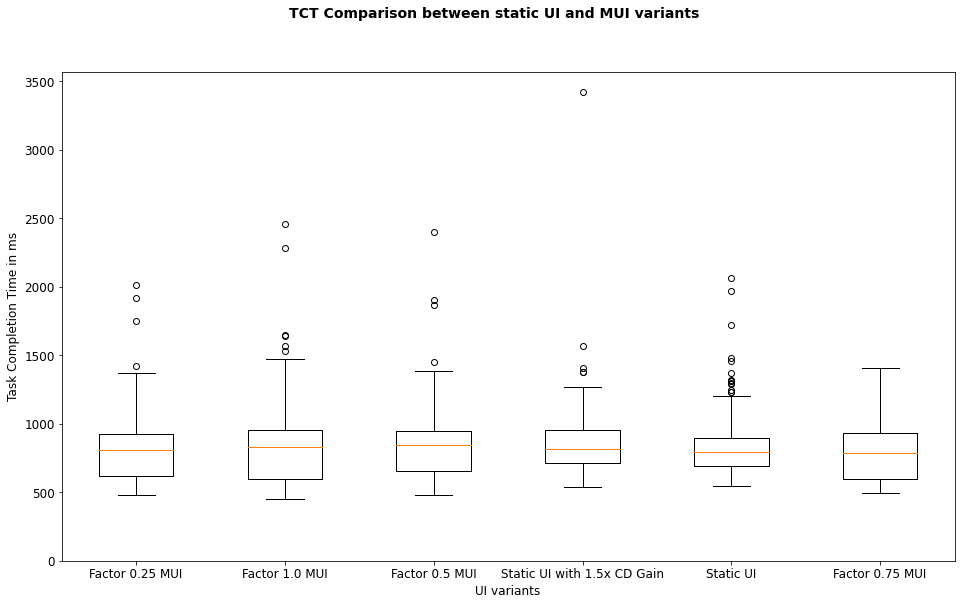

In [10]:
durations = {}

for condition in conditions:
    durations[condition[0].condition] = [run.run_duration for run in condition]
        
ticks = []
data = []

for condition, duration_measurements in durations.items(): 
    cond_name = "Warmup" if condition == -1 else "Static UI" if condition == 0 else "Factor 0.25 MUI" if condition == 1 else "Factor 0.5 MUI" if condition == 2 else "Factor 0.75 MUI" if condition == 3 else "Factor 1.0 MUI" if condition == 4  else "Static UI with 1.5x CD Gain" if condition == 5 else "Cooldown"
    
    range_mean_median_sd (cond_name, duration_measurements)
    print()
    
    if cond_name != "Warmup" and cond_name != "Cooldown":
        data.append(duration_measurements)
        ticks.append(cond_name)

fig = plt.figure()
fig.suptitle('TCT Comparison between static UI and MUI variants', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xlabel('UI variants')
ax.set_ylabel('Task Completion Time in ms')
ax.set_ylim(bottom=0)
xticks([i + 1 for i in range(len(ticks))], ticks)


In [11]:
from scipy.stats import ttest_rel as ttest

static_durations = durations[0]
factor025_durations = durations[1]
factor05_durations = durations[2]
factor075_durations = durations[3]
factor1_durations = durations[4]
static15cdg_durations = durations[5]

def getConditionName(cond):
    cond_name = "Static UI" if cond == 0 else "Factor 0.25 MUI" if cond == 1 else "Factor 0.5 MUI" if cond == 2 else "Factor 0.75 MUI" if cond == 3 else "Factor 1.0 MUI" if cond == 4  else "Static UI with 1.5x CD Gain"
    return cond_name
    
for cond in range(6):
    cond_name = getConditionName(cond)
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> p = {}".format(ttest(durations[cond], durations[condToCompare])[1]))
    print()

Static UI vs Factor 0.25 MUI -> p = 0.4905279834480607
Static UI vs Factor 0.5 MUI -> p = 0.7711418700203163
Static UI vs Factor 0.75 MUI -> p = 0.18334722965305048
Static UI vs Factor 1.0 MUI -> p = 0.963668761632166
Static UI vs Static UI with 1.5x CD Gain -> p = 0.2776335564492708

Factor 0.25 MUI vs Static UI -> p = 0.4905279834480607
Factor 0.25 MUI vs Factor 0.5 MUI -> p = 0.29454767104331747
Factor 0.25 MUI vs Factor 0.75 MUI -> p = 0.5538156230073061
Factor 0.25 MUI vs Factor 1.0 MUI -> p = 0.56174044583461
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> p = 0.10227074041692907

Factor 0.5 MUI vs Static UI -> p = 0.7711418700203163
Factor 0.5 MUI vs Factor 0.25 MUI -> p = 0.29454767104331747
Factor 0.5 MUI vs Factor 0.75 MUI -> p = 0.11613806163888893
Factor 0.5 MUI vs Factor 1.0 MUI -> p = 0.739967209548695
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> p = 0.4418946833065822

Factor 0.75 MUI vs Static UI -> p = 0.18334722965305048
Factor 0.75 MUI vs Factor 0.25 MUI -> p =

## Errors

In [12]:
def increase_in_percent(counter, denominator):
    return (counter / (denominator / 100)) - 100

errors = {}

for condition in conditions:
    errors[condition[0].condition] = sum([run.errors for run in condition])

for cond in range(6):
    cond_name = getConditionName(cond)
    print("Errors for " + cond_name + ": {}".format(errors[cond]))
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> {}%".format(increase_in_percent(errors[cond], errors[condToCompare])))
    print("")

Errors for Static UI: 38
Static UI vs Factor 0.25 MUI -> -15.555555555555557%
Static UI vs Factor 0.5 MUI -> -11.627906976744185%
Static UI vs Factor 0.75 MUI -> -2.564102564102569%
Static UI vs Factor 1.0 MUI -> -25.490196078431367%
Static UI vs Static UI with 1.5x CD Gain -> -44.927536231884055%

Errors for Factor 0.25 MUI: 45
Factor 0.25 MUI vs Static UI -> 18.421052631578945%
Factor 0.25 MUI vs Factor 0.5 MUI -> 4.651162790697683%
Factor 0.25 MUI vs Factor 0.75 MUI -> 15.384615384615387%
Factor 0.25 MUI vs Factor 1.0 MUI -> -11.764705882352942%
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> -34.78260869565217%

Errors for Factor 0.5 MUI: 43
Factor 0.5 MUI vs Static UI -> 13.15789473684211%
Factor 0.5 MUI vs Factor 0.25 MUI -> -4.444444444444443%
Factor 0.5 MUI vs Factor 0.75 MUI -> 10.256410256410248%
Factor 0.5 MUI vs Factor 1.0 MUI -> -15.686274509803923%
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> -37.68115942028985%

Errors for Factor 0.75 MUI: 39
Factor 0.75 MUI vs Sta

## Covered Distances

In [13]:
# covered_distance
mean_covered_distances_cursor = {}

for condition in conditions:
    mean_covered_distances_cursor[condition[0].condition] = sum([run.cursor_movement_length for run in condition]) / len([run.cursor_movement_length for run in condition])

In [14]:
static_mean_covered_distance = mean_covered_distances_cursor[0]
factor05_mean_covered_distance = mean_covered_distances_cursor[1]
factor1_mean_covered_distance = mean_covered_distances_cursor[2]
static15cdg_mean_covered_distance = mean_covered_distances_cursor[3]


for cond in range(6):
    cond_name = getConditionName(cond)
    print("Mean covered distance of cursor for " + cond_name + ": {}px".format(mean_covered_distances_cursor[cond]))

Mean covered distance of cursor for Static UI: 505.81378925140143px
Mean covered distance of cursor for Factor 0.25 MUI: 417.9027967551311px
Mean covered distance of cursor for Factor 0.5 MUI: 306.607575523296px
Mean covered distance of cursor for Factor 0.75 MUI: 283.95084392399446px
Mean covered distance of cursor for Factor 1.0 MUI: 279.98188145576916px
Mean covered distance of cursor for Static UI with 1.5x CD Gain: 519.3840926831847px


## Most notable observation

WIP